# Calculation of ICV (index of living conditions)

ICV calculated from 2010 census data (INEC 2010):
http://www.ecuadorencifras.gob.ec/documentos/datos/Poblacion_y_Demografia/Censo_poblacion_y_vivienda_/bdd_nivel_manzana_censal/Spss/CPV2010M_SPSS_Azuay.zip

Calculation of ICV for Census data in Ecuador proposed by Orellana & Osorio (2014):
https://ideas.repec.org/a/inp/inpana/v8y2014i2p27-38.html

In [1]:
library(haven)
library(plyr)
library(ggplot2)
library(ggthemes)

Warning message:
"package 'haven' was built under R version 3.4.1"Warning message:
"package 'ggthemes' was built under R version 3.4.1"

data in SPSS format

In [2]:
d_viv<-read_sav("input_data/Azuay_Viv_Manz.sav")
d_hog<-read_sav("input_data/Azuay_Hog_Manz.sav")
d_pob<-read_sav("input_data/Azuay_Pob_Manz.sav")
urbanArea_ids<-read.csv("input_data/cuenca_urban_block_ids.csv", colClasses = "character")

create new dataframes to store relevant values 

In [3]:
dwelling<-d_viv[,c('id_man','id_viv')]
home<-d_hog[,c('id_viv','id_hog')]
pop<-d_pob[,c('id_viv','id_hog')]

## Map scores to variables

In [4]:
#create dictionary to map variables
floor_dict<-list( '1'= 2, '2'=0 ,'3'=2,'4'=1,'5'=0, '6'=0,'7'=0, 'NA'=NA)
wall_dict<-list( '1'= 3, '2'= 3,'3'=2,'4'=2,'5'=1, '6'=0,'7'=0, 'NA'=NA)
roof_dict<-list( '1'=2 , '2'= 1,'3'=1,'4'=2,'5'=0, '6'=0, 'NA'=NA)
water_dict<-list( '1'=3, '2'=2 ,'3'=1,'4'=0, 'NA'=NA)
drainage_dict<-list( '1'=2, '2'=1 ,'3'=0,'4'=0, '5'=0,'6'=0 ,'NA'=NA)
waste_dict<-list( '1'=1, '2'=0 ,'3'=0,'4'=0, '5'=0,'6'=0 ,'NA'=NA)
electricity_dict<-list( '1'=1, '2'=1,'3'=1,'4'=1, '5'=0,'NA'=NA)
kitchen_dict<-list( '1'=1, '2'=0,'NA'=NA) 
bathroom_dict<-list( '1'= 1 , '2'= 0 , '3' = 0,'NA'= NA ) 
stove_dict<-list( '1'= 1 , '2'= 1 , '3' = 1, '4'= 0, '5'=0, '6'=0, '7'=0,'NA'= NA ) #H05
phone_dict<-list('1'=1, '2'=0, 'NA'=NA) 
cell_dict<-list('1'=1, '2'=0, 'NA'=NA) 
internet_dict<-list('1' =1 , '2'=0, 'NA'= NA) 
tv_dict<-list('1'=2 , '2'=1 , 'NA'=NA)
privhealthcare_dict<-list('1' = 1, '2'=0, '9'=0, 'NA' = NA)
pubhealthcare_dict<-list('1' = 1, '2'=1, '3'=1, '4' = 1, '5'= 1, '6'=1, '7'=0, '9'=0, 'NA' = NA)

In [5]:
#map variables to dataframes
dwelling$floor<-sapply(d_viv$V05, function(x) get(as.character(x), floor_dict)/2)
dwelling$walls<-sapply(d_viv$V03, function(x) get(as.character(x), wall_dict)/3)
dwelling$roof<-sapply(d_viv$V01, function(x) get(as.character(x), roof_dict)/2)
dwelling$water<-sapply(d_viv$V08, function(x) get(as.character(x), water_dict)/3)
dwelling$drainage<-sapply(d_viv$V09, function(x) get(as.character(x), drainage_dict))
dwelling$waste<-sapply(d_viv$V13, function(x) get(as.character(x), waste_dict))
dwelling$electricity<-sapply(d_viv$V10, function(x) get(as.character(x), electricity_dict))
dwelling$bedrooms<-(d_viv$TOTDOR / d_viv$TOTPER)
dwelling$rooms<-sapply(d_viv$V14-d_viv$TOTDOR, function(x) if(!is.na(x)){ if(x>0){1} else{0} } else{NA} )
home$kitchen<-sapply(d_hog$H02, function(x) get(as.character(x), kitchen_dict))
home$bathroom<-sapply(d_hog$H03, function(x) get(as.character(x), bathroom_dict))
home$stove<-sapply(d_hog$H05, function(x) get(as.character(x), stove_dict))
home$phone<-sapply(d_hog$H07, function(x) get(as.character(x), phone_dict))
home$cell<-sapply(d_hog$H08, function(x) get(as.character(x), cell_dict))
home$internet<-sapply(d_hog$H09, function(x) get(as.character(x), internet_dict))
home$tv<-sapply(d_hog$H11, function(x) get(as.character(x), tv_dict))
schooling_score<-function(schooling, age){
  if(!(is.na(schooling) || schooling==99)){
    if(age>18){
      return(schooling/13)
    }
    else if(age>5){
      return(schooling/(age-5))
    }
    else{0}
  }
  else{NA}
}

pop$schooling<-mapply(schooling_score, d_pob$GRAESC, d_pob$P03)
pop$privhealthcare<-sapply(d_pob$P07, function(x) get(as.character(x), privhealthcare_dict))
pop$pubhealthcare<-sapply(d_pob$P35, function(x) get(as.character(x), pubhealthcare_dict))
pop$healthcare<-sapply(pop$privhealthcare+pop$pubhealthcare, function(x) if(!is.na(x)){ if(x>0){1}else{0.5} }else{NA})   
    

## Rescale relevant values (0-2)

In [6]:
#rescale number of bedrooms and schooling
dwelling$bedrooms_rs<-sapply(dwelling$bedrooms, function(x) if(!is.na(x)){ if(x>0){ 1 + ((x-1)/(max(dwelling$bedrooms, na.rm = T)-1)) }else{0} }else{NA} )

#rescale schooling score
pop$schooling_rs<-sapply(pop$schooling, function(x) if(!is.na(x)){ if(x>0){ 1 + ((x-1)/(max(pop$schooling, na.rm = T)-1)) }else{0} }else{NA} )

## Aggregate population scores to home units

In [7]:
pop_mean<-ddply(pop, .(id_hog), summarize, 
                num_people = length(id_hog), 
                schooling = mean(schooling_rs, na.rm = T), 
                healthcare = mean(healthcare, na.rm = T))
home<-merge(home, pop_mean, by='id_hog')

## Aggregate home unit scores to dwelling units

In [8]:
home_mean<-ddply(home, .(id_viv), summarize, 
      num_homes = length(id_viv),
      num_people = sum(num_people, na.rm = T),
      kitchen = mean(kitchen, na.rm = T),
      bathroom = mean(bathroom, na.rm = T),
      stove = mean(stove, na.rm = T),
      phone = mean(phone, na.rm = T),
      cell = mean(cell, na.rm = T),
      internet = mean(internet, na.rm = T),
      tv = mean(tv, na.rm = T),
      healthcare = mean(healthcare, na.rm = T), 
      schooling = mean(schooling, na.rm = T)
      )
dwelling<-merge(dwelling, home_mean, by = 'id_viv')

## Weighted sum of scores (ICV index at dwelling level)

In [9]:
dwelling$ICV<- dwelling$floor*((1/3)*(1/2)*(1/4)) + 
  dwelling$walls*((1/3)*(1/2)*(1/4)) + 
  dwelling$roof*((1/3)*(1/2)*(1/4)) +
  dwelling$kitchen*((1/4)*(1/2)*(1/4)) + 
  dwelling$bathroom*((1/4)*(1/2)*(1/4)) +
  dwelling$bedrooms_rs*((1/4)*(1/2)*(1/4)) +
  dwelling$rooms*((1/4)*(1/2)*(1/4)) + 
  dwelling$water*((2/5)*(1/2)*(1/4)) + 
  dwelling$drainage*((2/5)*(1/2)*(1/4)) + 
  dwelling$waste*((1/5)*(1/2)*(1/4)) + 
  dwelling$electricity*((1/2)*(1/4)*(1/4)) + 
  dwelling$stove*((1/2)*(1/4)*(1/4)) + 
  dwelling$phone*((1/4)*(1/4)*(1/4)) + 
  dwelling$cell*((1/4)*(1/4)*(1/4)) +
  dwelling$internet*((1/4)*(1/4)*(1/4)) +
  dwelling$tv*((1/4)*(1/4)*(1/4)) + 
  dwelling$schooling*(1/4) + 
  dwelling$healthcare*(1/4)

## Group values based on quantlies

In [10]:
#subset only Cuenca Urban Area
ids <- urbanArea_ids$DPA_MANZAN
dwelling <- dwelling[which(dwelling$id_man %in% ids),]
#group by quantiles
dwelling$quartile <- with(dwelling, cut(ICV,
                                        breaks=quantile(ICV, probs=seq(0,1, by=0.25), na.rm=TRUE),
                                        include.lowest=TRUE, labels = c('Q1', 'Q2', 'Q3', 'Q4')))

## Aggregate groups to block level

In [11]:
#measured as percentage of population within block belonging to group
blockICV<-ddply(dwelling, .(id_man), summarize, 
                Q1 = sum(num_people[which(quartile == 'Q1')]) / sum(num_people), 
                Q2 = sum(num_people[which(quartile == 'Q2')]) / sum(num_people),
                Q3 = sum(num_people[which(quartile == 'Q3')]) / sum(num_people),
                Q4 = sum(num_people[which(quartile == 'Q4')]) / sum(num_people),
                ICV = mean(ICV, na.rm=TRUE),
                nDwellings = sum(num_homes),
                nPeople = sum(num_people)
                )

## Output results to CSV

In [12]:
write.csv(dwelling, file = "output_data/ICV_viv.csv", row.names = FALSE)
write.csv(blockICV, file = "output_data/blockICV.csv", row.names = FALSE)

## Create Plots to explore data

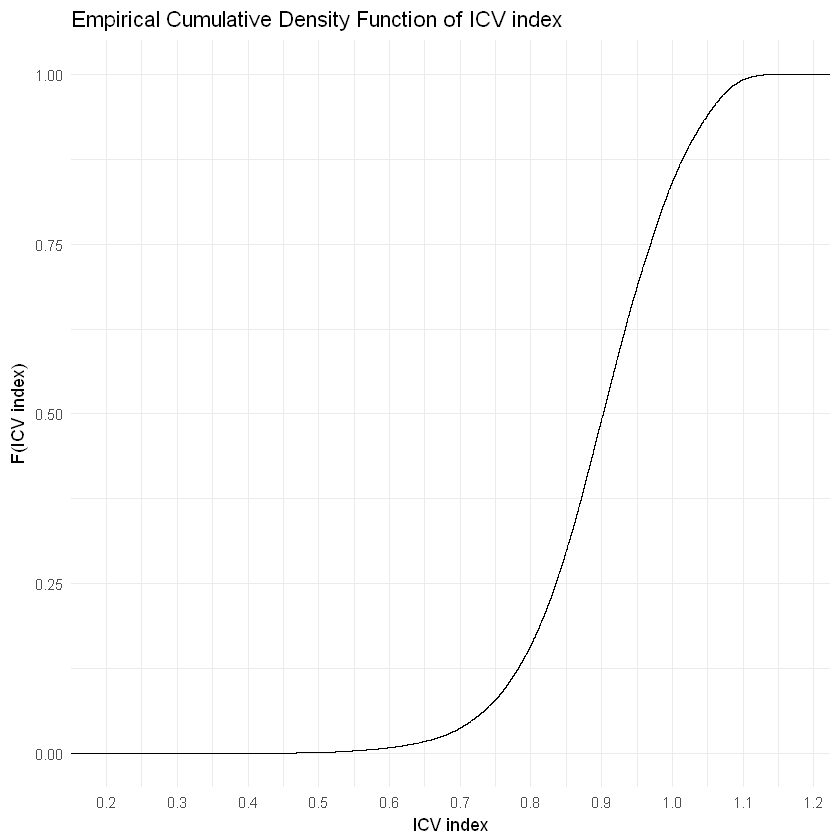

In [36]:
# data <- dwelling[which(!is.na(dwelling$ICV)),]
# data<- merge(data, home, by = 'id_viv')
# data<-merge(data, pop, by = 'id_hog')

# data$ <- block

# ggplot(data = data, aes(ICV)) + 
#     geom_histogram(aes(y = ..density..),
#                    breaks = seq(0.5,1.5,by = 0.025),
#                   ) + 
#     geom_density(col=2)+
#     labs(title = "Frequency distribution of ICV values per block",
#          x = 'ICV index',
#          y = '') + theme_minimal()

# ggplot(data = data, aes(ICV)) + 
#     geom_histogram(aes(y = ..density..),
#                    breaks = seq(0.5,1.5,by = 0.025),
#                   ) + 
#     geom_density(col=2)+
#     labs(title = "Population in Each Quartile",
#          x = 'ICV index',
#          y = '') + theme_minimal()

myplot <-ggplot(data, aes(ICV)) + stat_ecdf(geom = "step") + 
    labs(title = "Empirical Cumulative Density Function of ICV index",
     y = "F(ICV index)",
     x = "ICV index"
    ) + 
    scale_x_continuous(breaks = seq(from=0, to=1.5, by=0.1))+
    theme_minimal()
myplot
# ggsave("ICV.pdf")

# ggplot(data, aes(ICV, ..density..)) + 
#     geom_histogram(binwidth=.05,
#                    colour="black", fill="white") +
#     geom_density(color = 'red')+
#     labs(title = "ICV index values for Cuenca",
#          y = "Density",
#          x = "ICV index"
#         ) + 
#     geom_vline(aes(xintercept=mean(ICV, na.rm=T)), color = 'red', linetype = 'dashed')+
#     scale_x_continuous(breaks = seq(from=0, to=1.5, by=0.1))+
#     theme_minimal()
# ggsave("ICV2.pdf")